# Set-up

## Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.decomposition import NMF

from utils import plot_components, normalize_curves
from lcnmf import LCNMF, _loss_nmf, _loss_constraint_c, _loss_constraint_s
from blind_separation import get_curves_info, process_sector_consumption, get_indicators, get_Y, get_B, get_D, initialize_C

In [2]:
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [3]:
curves_infile = 'data/daily_curves.csv'
consumption_file = 'data/1_input/consumption/consumption.xlsx'
imser_file = 'data/1_input/indicators/IMSER2.xlsx'
imcei_file = 'data/1_input/indicators/IMCEI_mensile.xlsx'
enel_files = [
    'data/1_input/indicators/Domestico 2020 e 2021.xlsx', 
    'data/1_input/indicators/Domestico 2022 e 2023.xlsx'
]

n_components = 5

## Functions

# Create matrices for LCNMF

$$
(\hat{C}, \hat{S}) = \text{argmin}_{C \in \mathbb{R}_+^{n \times K},\, S \in \mathbb{R}_+^{K \times p}} \,
\left\lVert X - C S \right\rVert_{F}^2 +
\alpha \left\lVert B C A - Y \right\rVert_{F}^2 +
\beta \left\lVert E S D - Z \right\rVert_{F}^2
$$

## Data matrix $X$

In [4]:
curves_df = pd.read_csv(curves_infile, index_col=0)
curves_info = get_curves_info(curves_df)
X = normalize_curves(curves_df)
n, p = X.shape
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,0.040803,0.038886,0.035334,0.033238,0.031889,0.032188,0.033692,0.034905,0.035071,0.037756,0.041545,0.044978,0.049857,0.048650,0.043681,0.042926,0.043763,0.048017,0.049442,0.050427,0.050274,0.047813,0.045368,0.041204,0.037392
Italy_2021-01-02_Saturday,0.034582,0.031817,0.030355,0.029420,0.029645,0.030477,0.033313,0.035742,0.038388,0.041735,0.045665,0.047741,0.047613,0.046995,0.045364,0.044692,0.045697,0.050693,0.052824,0.053599,0.051233,0.047675,0.044239,0.039821,0.035934
Italy_2021-01-03_Holiday,0.037136,0.034000,0.032340,0.031203,0.030766,0.031843,0.033620,0.035059,0.036471,0.040169,0.043397,0.045904,0.048865,0.045910,0.044195,0.043728,0.044653,0.049015,0.050888,0.053074,0.052575,0.048646,0.045187,0.041296,0.037256
Italy_2021-01-04_Monday,0.029418,0.027064,0.025802,0.025455,0.025877,0.027024,0.031138,0.037437,0.043145,0.047889,0.050185,0.049953,0.048993,0.048452,0.048601,0.049408,0.049332,0.051916,0.052597,0.052436,0.049890,0.045963,0.041847,0.037930,0.033916
Italy_2021-01-05_Working day,0.032700,0.029969,0.028335,0.027614,0.027737,0.028593,0.032544,0.038216,0.043890,0.047585,0.049173,0.049884,0.049130,0.048181,0.048546,0.048687,0.048577,0.051137,0.050909,0.049935,0.047810,0.044150,0.040411,0.036294,0.032685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2022-12-27_Working day,0.030036,0.027821,0.026554,0.026069,0.026217,0.027796,0.032337,0.038829,0.044725,0.049958,0.050131,0.049527,0.049112,0.047519,0.047199,0.048236,0.048066,0.051586,0.051861,0.051639,0.049392,0.045694,0.041235,0.037001,0.032953
Italy_2022-12-28_Working day,0.032080,0.029201,0.027784,0.027227,0.027290,0.028743,0.032937,0.039100,0.044587,0.049320,0.050316,0.049248,0.048476,0.046101,0.046440,0.047582,0.047709,0.051298,0.051469,0.051628,0.049047,0.045292,0.040747,0.036293,0.032247
Italy_2022-12-29_Working day,0.032947,0.029926,0.028523,0.027881,0.027842,0.029273,0.033568,0.039620,0.044967,0.049341,0.049411,0.047486,0.047083,0.045786,0.046808,0.046613,0.047587,0.051393,0.051613,0.051689,0.049072,0.045257,0.040474,0.036186,0.032254
Italy_2022-12-30_Working day,0.033408,0.030582,0.029177,0.028505,0.028549,0.029877,0.033448,0.039036,0.044164,0.048588,0.049262,0.048863,0.047513,0.044573,0.045149,0.045902,0.047010,0.050771,0.051797,0.051806,0.049720,0.045028,0.040957,0.036645,0.032748


## Create ASC and MSI matrix $\mathrm{Y}$

In [5]:
year_totals = curves_info.groupby('year')['cons'].sum()
year_month_totals = curves_info.groupby(['year', 'month'])['cons'].sum()

cons_df = process_sector_consumption(consumption_file, year_totals)
indics_df = get_indicators(imser_file, imcei_file, enel_files)

Y = get_Y(indics_df, cons_df, year_month_totals)
Y

,Domestic,Industry,Services
Mese,,,
2021-01-01,7140.915027,11919.077661,8021.876794
2021-02-01,5798.208878,12027.588273,7152.953381
2021-03-01,6034.945900,13395.272065,7239.429554
2021-04-01,5426.688341,12536.637147,6532.997014
2021-05-01,4902.511816,13091.845812,6987.220874
2021-06-01,5422.083542,13273.770662,8726.013316
2021-07-01,6449.235365,13880.930491,10103.689659
2021-08-01,7093.269686,9495.985836,10081.852017
2021-09-01,5079.594569,13586.250458,8319.998966


## Create parameter matices $\mathrm{B}$ and $\mathrm{A}$

In [6]:
B = get_B(curves_df)
B

,Italy_2021-01-01_Holiday,Italy_2021-01-02_Saturday,Italy_2021-01-03_Holiday,Italy_2021-01-04_Monday,Italy_2021-01-05_Working day,Italy_2021-01-06_Holiday,Italy_2021-01-07_Working day,Italy_2021-01-08_Working day,Italy_2021-01-09_Saturday,Italy_2021-01-10_Holiday,Italy_2021-01-11_Monday,Italy_2021-01-12_Working day,Italy_2021-01-13_Working day,Italy_2021-01-14_Working day,Italy_2021-01-15_Working day,Italy_2021-01-16_Saturday,Italy_2021-01-17_Holiday,Italy_2021-01-18_Monday,Italy_2021-01-19_Working day,Italy_2021-01-20_Working day,Italy_2021-01-21_Working day,Italy_2021-01-22_Working day,Italy_2021-01-23_Saturday,Italy_2021-01-24_Holiday,Italy_2021-01-25_Monday,Italy_2021-01-26_Working day,Italy_2021-01-27_Working day,Italy_2021-01-28_Working day,Italy_2021-01-29_Working day,Italy_2021-01-30_Saturday,Italy_2021-01-31_Holiday,Italy_2021-02-01_Monday,Italy_2021-02-02_Working day,Italy_2021-02-03_Working day,Italy_2021-02-04_Working day,Italy_2021-02-05_Working day,Italy_2021-02-06_Saturday,Italy_2021-02-07_Holiday,Italy_2021-02-08_Monday,Italy_2021-02-09_Working day,...,Italy_2022-11-22_Working day,Italy_2022-11-23_Working day,Italy_2022-11-24_Working day,Italy_2022-11-25_Working day,Italy_2022-11-26_Saturday,Italy_2022-11-27_Holiday,Italy_2022-11-28_Monday,Italy_2022-11-29_Working day,Italy_2022-11-30_Working day,Italy_2022-12-01_Working day,Italy_2022-12-02_Working day,Italy_2022-12-03_Saturday,Italy_2022-12-04_Holiday,Italy_2022-12-05_Monday,Italy_2022-12-06_Working day,Italy_2022-12-07_Working day,Italy_2022-12-08_Holiday,Italy_2022-12-09_Working day,Italy_2022-12-10_Saturday,Italy_2022-12-11_Holiday,Italy_2022-12-12_Monday,Italy_2022-12-13_Working day,Italy_2022-12-14_Working day,Italy_2022-12-15_Working day,Italy_2022-12-16_Working day,Italy_2022-12-17_Saturday,Italy_2022-12-18_Holiday,Italy_2022-12-19_Monday,Italy_2022-12-20_Working day,Italy_2022-12-21_Working day,Italy_2022-12-22_Working day,Italy_2022-12-23_Working day,Italy_2022-12-24_Saturday,Italy_2022-12-25_Holiday,Italy_2022-12-26_Holiday,Italy_2022-12-27_Working day,Italy_2022-12-28_Working day,Italy_2022-12-29_Working day,Italy_2022-12-30_Working day,Italy_2022-12-31_Saturday
2021-01,612.349503,662.107498,640.667495,811.363504,841.526504,721.363001,924.750503,948.432509,799.0985,721.477,978.827501,1008.17,1003.209001,1003.227,1007.3675,825.177001,746.572993,994.127497,1025.745003,1021.405494,991.024498,965.314001,783.478996,685.53699,940.589504,992.434995,1016.967499,994.878994,957.376998,771.589498,685.712501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.00,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,942.412006,988.581996,985.545003,962.058494,954.439001,762.699,663.156002,886.275499,947.417003,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.00,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.

In [7]:
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])

## Specify $\mathrm{E}$, $\mathrm{D}$ and $\mathrm{Z}$ matrices for constraints on $S$

In [8]:
E = np.eye(n_components)
Z = np.ones((n_components, 1))

# Creating matrix D is a little more complicated as the multiplication of each row of S with the column matrix D should give the functional norm
# The lines below essentially consist in writing the functional_norm as a vectorized function
D = get_D(p)

# Find suitable $\alpha$ and $\beta$ regularisation parameters

## Search $\alpha$ and $\beta$

In [9]:
C_init = initialize_C(X, n_components)
S_init = normalize_curves(np.ones((n_components, p)))

loss_nmf = _loss_nmf(X, C_init, S_init)
loss_constraint_c = _loss_constraint_c(Y, B.values, C_init, A)
loss_constraint_s = _loss_constraint_s(Z, E, S_init, D)

print(loss_nmf, loss_constraint_c, loss_constraint_s)
print(loss_nmf / loss_constraint_c)

0.9532598869074205 1943565037.1800718 1.232595164407831e-32
4.904697649277073e-10


In [10]:
# The term that beta controls is the sum of n_component deviations from the unit-functional-normed vector, so we can safely set it to 1 or 0.1
beta = 1

In [16]:
### Search for alphas ###

n_alphas = 20
pow_min = -11
pow_max = -8
alphas = 10 ** np.linspace(pow_min, pow_max, n_alphas)
# alphas = np.linspace(1e-10, 1e-9, n_alphas) # for uniform initilisation 5 components
# alphas = np.linspace(5e-10, 5e-9, n_alphas) # for uniform initilisation 3 components
n_runs = 10

n_iter_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_nmf_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_constraint_c_df = pd.DataFrame(columns=alphas, index=range(n_runs))
loss_constraint_s_df = pd.DataFrame(columns=alphas, index=range(n_runs))

for alpha in tqdm(alphas):
    n_iter = []
    loss_nmf = []
    loss_constraint_c = []
    loss_constraint_s = []

    model = LCNMF(
        n_components=n_components,
        alpha=alpha,
        beta=beta
    )

    for runs in range(n_runs):
        C_init = initialize_C(X, n_components)
        C = model.fit_transform(X.values, C_init.values, S_init, Y.values, A, B.values, Z, D, E)

        n_iter.append(model.n_iter_)
        loss_nmf.append(model.losses_nmf_[-1])
        loss_constraint_c.append(model.losses_constraint_c_[-1])
        loss_constraint_s.append(model.losses_constraint_s_[-1])
    
    n_iter_df[alpha] = n_iter
    loss_nmf_df[alpha] = loss_nmf
    loss_constraint_c_df[alpha] = loss_constraint_c
    loss_constraint_s_df[alpha] = loss_constraint_s


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


<Axes: >

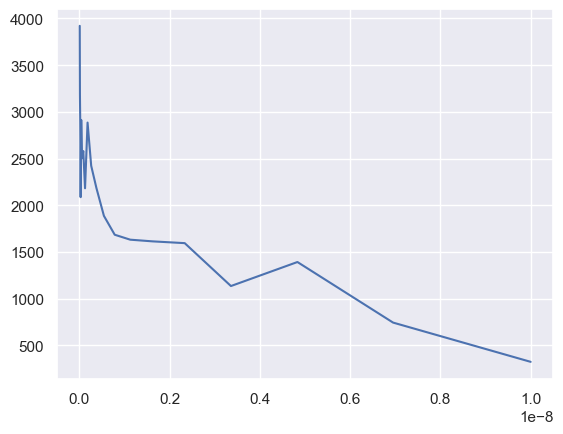

In [17]:
n_iter_df.mean(axis=0).plot()

<Axes: >

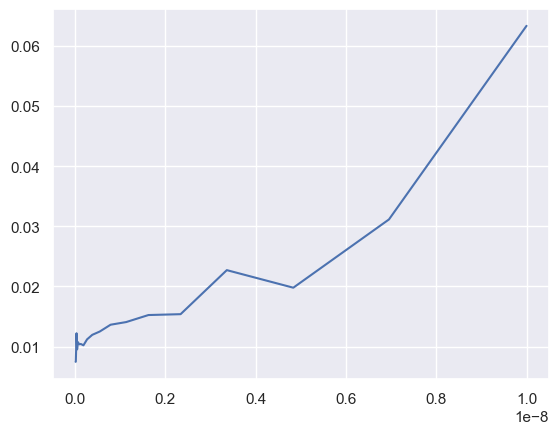

In [18]:
loss_nmf_df.mean(axis=0).plot()

<Axes: >

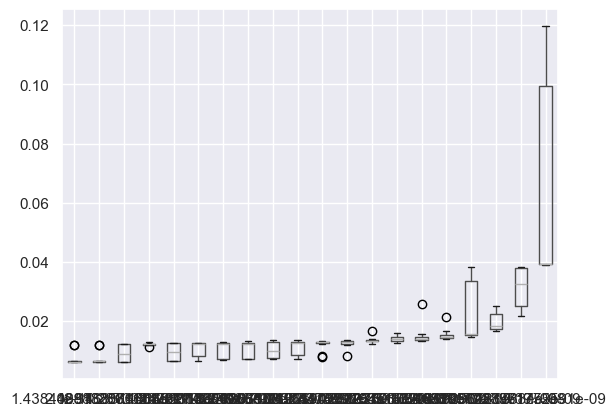

In [19]:
loss_nmf_df.boxplot()

In [20]:
loss_nmf_df.median(axis=0)

1.000000e-11    0.006335
1.438450e-11    0.006401
2.069138e-11    0.008933
2.976351e-11    0.012299
4.281332e-11    0.009436
6.158482e-11    0.012291
8.858668e-11    0.012262
1.274275e-10    0.012142
1.832981e-10    0.009844
2.636651e-10    0.012632
3.792690e-10    0.012925
5.455595e-10    0.013031
7.847600e-10    0.013370
1.128838e-09    0.013815
1.623777e-09    0.013921
2.335721e-09    0.014609
3.359818e-09    0.015816
4.832930e-09    0.018505
6.951928e-09    0.032458
1.000000e-08    0.039351
dtype: float64

In [21]:
loss_nmf_df

,1.000000e-11,1.438450e-11,2.069138e-11,2.976351e-11,4.281332e-11,6.158482e-11,8.858668e-11,1.274275e-10,1.832981e-10,2.636651e-10,3.792690e-10,5.455595e-10,7.847600e-10,1.128838e-09,1.623777e-09,2.335721e-09,3.359818e-09,4.832930e-09,6.951928e-09,1.000000e-08
0,0.006474,0.006279,0.012441,0.011405,0.012685,0.006718,0.012959,0.012404,0.007469,0.007470,0.012968,0.013218,0.013897,0.014147,0.013549,0.014587,0.038001,0.023951,0.025011,0.038917
1,0.012110,0.012095,0.006569,0.012065,0.012632,0.012648,0.006828,0.007290,0.007511,0.012854,0.007951,0.012292,0.016790,0.014634,0.013744,0.021464,0.038298,0.018647,0.038463,0.038830
2,0.006331,0.006327,0.006399,0.012435,0.012570,0.012715,0.012571,0.007283,0.012177,0.012939,0.013169,0.012796,0.013481,0.013540,0.013425,0.013834,0.015178,0.017452,0.021772,0.039586
3,0.006238,0.012112,0.006333,0.012347,0.006736,0.012169,0.007215,0.012195,0.007279,0.012891,0.013335,0.013274,0.012356,0.014090,0.013827,0.014180,0.038388,0.017170,0.028364,0.039310
4,0.006244,0.006376,0.012379,0.012013,0.006619,0.012585,0.007055,0.013286,0.013127,0.007456,0.012791,0.012843,0.013883,0.015971,0.014337,0.014177,0.014916,0.022745,0.038274,0.039159
5,0.006339,0.006214,0.012408,0.012361,0.012230,0.012208,0.011953,0.012732,0.007461,0.013066,0.012362,0.008146,0.013262,0.012670,0.015657,0.014630,0.014625,0.021001,0.038175,0.119449
6,0.012121,0.006426,0.006366,0.012250,0.006812,0.006896,0.006964,0.007328,0.013593,0.012409,0.013055,0.013792,0.013269,0.015789,0.014014,0.014634,0.020560,0.018362,0.022286,0.039392
7,0.006274,0.006458,0.011296,0.012166,0.012059,0.006634,0.012656,0.012088,0.007502,0.007278,0.012882,0.013559,0.012923,0.013257,0.025689,0.016697,0.015729,0.016607,0.024990,0.039192
8,0.006384,0.006291,0.006291,0.012459,0.006535,0.012586,0.012797,0.012742,0.013379,0.013561,0.013066,0.013223,0.013470,0.013318,0.014635,0.015678,0.015903,0.017034,0.037407,0.119315
9,0.006321,0.006529,0.011930,0.012805,0.006660,0.012373,0.013025,0.007063,0.012789,0.012243,0.008104,0.012058,0.013155,0.013448,0.013682,0.014108,0.015531,0.024994,0.036552,0.119683


<Axes: >

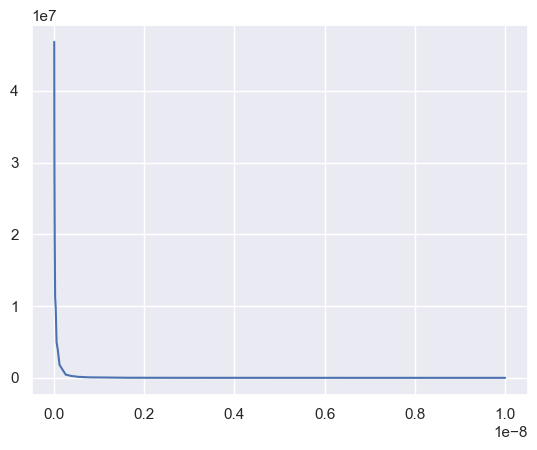

In [22]:
loss_constraint_c_df.mean(axis=0).plot()

<Axes: >

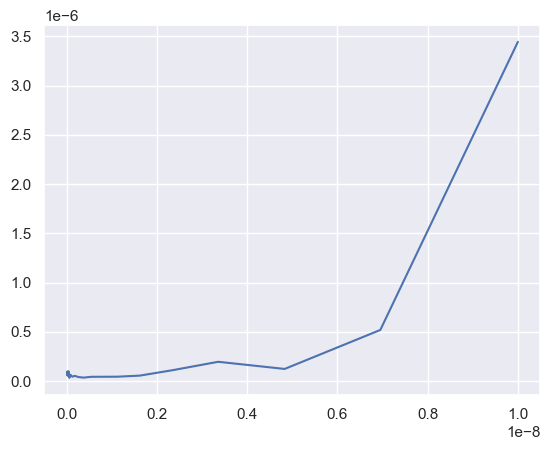

In [23]:
loss_constraint_s_df.mean(axis=0).plot()

Text(0.5, 0, 'alpha')

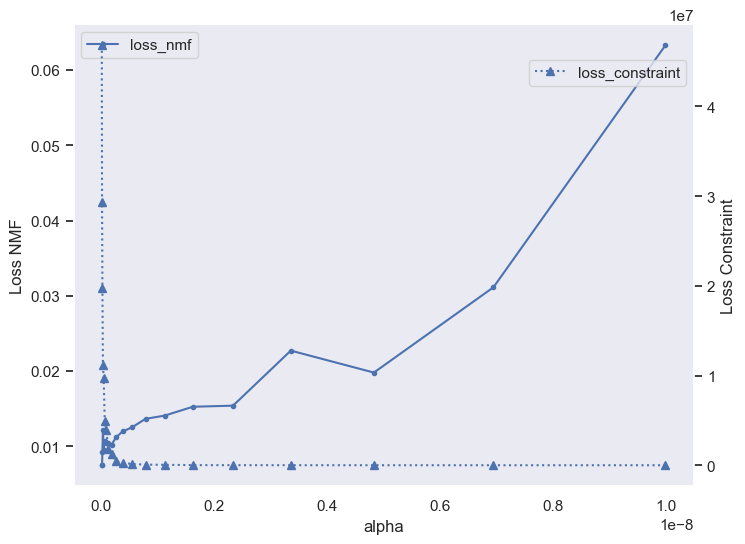

In [24]:
plt.figure(figsize=(8, 6))
ax1 = plt.gca()
loss_nmf_df.mean(axis=0).plot(ax=ax1, label='loss_nmf', marker='.')
ax1.grid(None)
ax1.legend()
ax1.set_ylabel('Loss NMF')

ax2 = ax1.twinx()
loss_constraint_c_df.mean(axis=0).plot(ax=ax2, label='loss_constraint', marker='^', linestyle='dotted')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))
ax2.set_ylabel('Loss Constraint')
ax1.set_xlabel('alpha')
# plt.xlim((0, 1e-8))

In [25]:
loss_nmf = loss_nmf_df.mean(axis=0).values
loss_constraint_c = loss_constraint_c_df.mean(axis=0).values
loss_constraint_s = loss_constraint_s_df.mean(axis=0).values

# Create the hover text with indices
hover_text_nmf = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss NMF: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_nmf))]
hover_text_constraint_c = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss Constraint C: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_constraint_c))]
hover_text_constraint_s = [f"Index: {i}<br>Alpha: {alpha:.1e}<br>Loss Constraint S: {loss}" for i, (alpha, loss) in enumerate(zip(alphas, loss_constraint_s))]

# Create traces
trace1 = go.Scatter(
    x=alphas,
    y=loss_nmf,
    mode='lines+markers',
    name='Loss NMF',
    marker=dict(symbol='circle'),
    line=dict(shape='linear'),
    hovertemplate=hover_text_nmf
)

trace2 = go.Scatter(
    x=alphas,
    y=loss_constraint_c,
    mode='lines+markers',
    name='Loss Constraint C',
    marker=dict(symbol='triangle-up'),
    line=dict(shape='linear', dash='dot'),
    yaxis='y2',
    hovertemplate=hover_text_constraint_c
)

trace3 = go.Scatter(
    x=alphas,
    y=loss_constraint_s,
    mode='lines+markers',
    name='Loss Constraint S',
    marker=dict(symbol='diamond'),
    line=dict(shape='linear', dash='dot'),
    yaxis='y1',
    hovertemplate=hover_text_constraint_s
)


# Create layout
layout = go.Layout(
    title='Loss vs Alpha',
    xaxis=dict(
        title='Alpha',
        type='log',  # Use logarithmic scale for x-axis
        # range=[-8, -5],  # Adjust range for log scale
        showgrid=False
    ),
    yaxis=dict(
        title='Loss NMF',
    ),
    yaxis2=dict(
        title='Loss Constraint',
        overlaying='y',
        side='right'
    ),
    width=800,
    height=600,
    legend=dict(x=1, y=0.94)
)

# Create figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# pio.write_html(fig, file='plot.html', auto_open=True)

# Show plot
fig.show()

## Check evolution of loss for selected $\alpha$ and $\beta$

In [26]:
tol = 1e-5
max_iter = 10000
verbose = 0
alpha = 3e-10
beta = 1

model = LCNMF(
    n_components=n_components,
    alpha=alpha,
    beta=beta,
    tol=tol,
    max_iter=max_iter,
    verbose=0
)

S_init = normalize_curves(np.ones((n_components, p)))
C_init = initialize_C(X, n_components)

C = model.fit_transform(X, C_init.values, S_init, Y, A, B.values, Z, D, E)

Total loss:  0.013937613300102347

Loss NMF:  0.013774378435417102
Loss constraint:  544116.2156174819


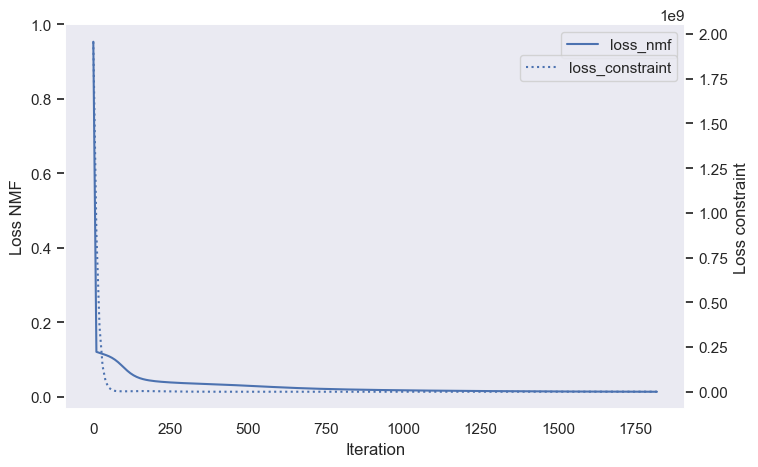

In [27]:
n_iter = model.n_iter_
losses_nmf = model.losses_nmf_
losses_constraint = model.losses_constraint_c_
# losses_constraint_s = model.losses_constraint_s_

plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax1.plot(np.arange(0, n_iter + 1, 10), losses_nmf, label='loss_nmf')
ax1.grid(None)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(np.arange(0, n_iter + 1, 10), losses_constraint, linestyle='dotted', label='loss_constraint')
ax2.grid(None)
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss NMF')
ax2.set_ylabel('Loss constraint')

print("Total loss: ", losses_nmf[-1] + alpha * losses_constraint[-1])
print("\nLoss NMF: ", losses_nmf[-1])
print("Loss constraint: ", losses_constraint[-1])

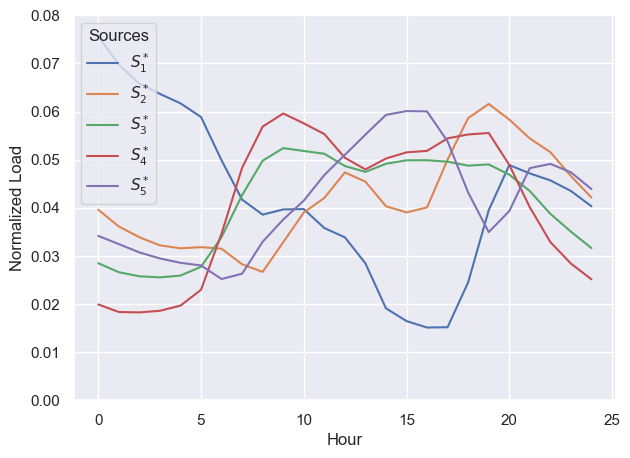

In [29]:
plot_components(model.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.08))

In [30]:
# Check L^1-norms
model.components_.dot(D)

array([[1.00028394],
       [0.99998596],
       [0.99974408],
       [0.99996675],
       [0.99995586]])

## Compare results with NMF

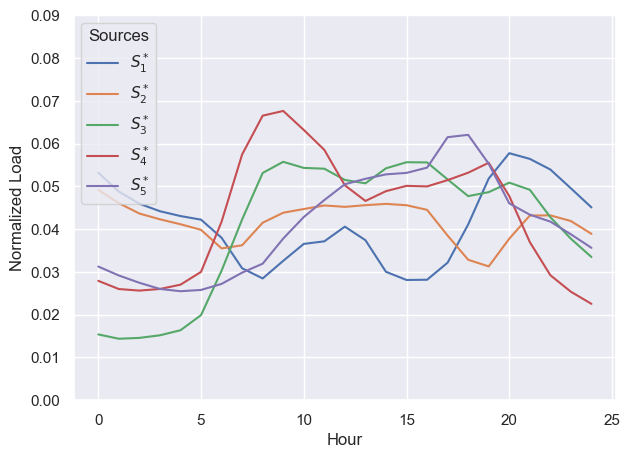

In [31]:
nmf = NMF(
        n_components=n_components,
        solver='mu',
        tol=tol,
        init='custom',
        max_iter=max_iter,
        verbose=verbose
)

C = nmf.fit_transform(
            X.values,
            W=C_init.values.copy(order='C'),
            H=S_init
        )

plot_components(nmf.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.09))

<Axes: >

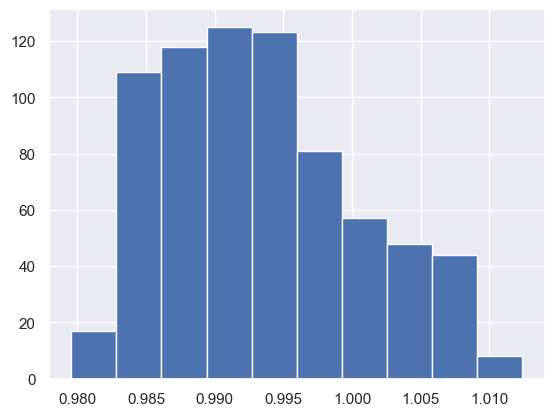

In [32]:
concentrations = pd.DataFrame(C, index=X.index)
concentrations.sum(axis=1).hist()

In [33]:
_loss_nmf(X, C, nmf.components_)

0.0059036222335898956

<HR>

# Tests